In [31]:
import sys
import os
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt  # To visualize
import numpy as np
from sklearn import mixture, datasets

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [8]:
#Get folder location from args
print(str(sys.argv[0]))
base_directory = '/mnt/DownloadsWindowsShared/Experiment_compare_swarm_and_simulator/Experiment2/attempt2/'

#Processing the folders in order
experiment_type = []
experiment_type_part1 = []
experiment_type_part2 = []

for dir_name in os.listdir(base_directory):
    experiment_type_part1.append(int(dir_name.split('_')[0]))
    experiment_type_part2.append(str(dir_name.split('_')[1]))

experiment_type_part1.sort()
for dir_nr in range(len(experiment_type_part1)):
    experiment_type.append(str(experiment_type_part1[dir_nr]) + "_" + experiment_type_part2[dir_nr])

tmp_frames = [[],[],[],[]]
data_frames = []
for dir_name in experiment_type:
    for experiment_folder in os.listdir(base_directory + "/" + dir_name):
        tmp_frames[0].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal.csv", names=["txns", "duration"]))
        #tmp_frames[1].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_mempool_process_incoming_transactions.csv", names=["txns", "duration"]))
        tmp_frames[1].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_new_round.csv", names=["txns", "duration", "timeout_round", "timestamp"]))
        tmp_frames[2].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_ensure_round_and_sync_up.csv", names=["txns", "duration"]))
        tmp_frames[3].append(pd.read_csv(base_directory + "/" + dir_name + "/" + experiment_folder + "/merged/jp_consensus_process_proposal_without_sync.csv", names=["txns", "duration"]))

    #Only take the log data for 1000 transactions
    for i in range(len(tmp_frames)):
        for j in range(len(tmp_frames[i])):
            tmp_frames[i][j] = tmp_frames[i][j][tmp_frames[i][j]['txns'] == max(tmp_frames[i][j]['txns'])]
    
    #merge the files
    for frames in tmp_frames:
        data_frames.append(pd.concat(frames))
    
    tmp_frames = [[],[],[],[]]
        
              
#convert duration from microseconds to milliseconds
i = 0
while i < len(data_frames):
    data_frames[i]["duration"] *= .001
    data_frames[i] = data_frames[i]
    i += 1

print("#entries(0):", len(data_frames[0]))
print("#entries(1):", len(data_frames[1]))
print("#entries(2):", len(data_frames[2]))
print("#entries(3):", len(data_frames[3]))
print("#entries(4):", len(data_frames[4]))
print(len(data_frames))

/home/jeanpierre/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py
#entries(0): 5256
#entries(1): 1053
#entries(2): 5260
#entries(3): 5256
#entries(4): 3567
52


In [4]:
def get_dist_parameters(index, calculate_round_sync_percentage):
    data = data_frames[index]['duration']
    data = data[data >= 40]
    
    percentage = 1
    if calculate_round_sync_percentage:
        percentage = 1 - ((len(data_frames[index]['duration']) - len(data)) / len(data_frames[index]['duration']))
    
    #Clean the data a bit
    data = data[data.between(data.quantile(0), data.quantile(.98))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    
    #Gamma dist
    a, loc_gamma, scale_gamma = stats.gamma.fit(data)
    gamma_fit = stats.gamma(a, loc_gamma, scale_gamma)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    #Beta dist
    alpha, beta, loc_beta, scale_beta = stats.beta.fit(data)
    beta_fit = stats.beta(alpha, beta, loc_beta, scale_beta)
    p_beta_fit = stats.kstest(data, beta_fit.cdf)
    
    if p_gamma_fit[1] >= p_beta_fit[1]:
        sys.stdout.write("gamma:" + str(a) + ":" + str(loc_gamma) + ":" + str(scale_gamma))
    else:
        sys.stdout.write("beta:" + str(alpha) + ":" + str(beta) + ":" + str(loc_beta) + ":" + str(scale_beta))
        
    if calculate_round_sync_percentage:
        sys.stdout.write(":" + str(percentage))
        
    sample_size = int(round(5000*percentage))
    if p_gamma_fit[1] >= p_beta_fit[1]:
        return stats.gamma.rvs(a, loc_gamma, scale_gamma, size=sample_size)
    else:
        return stats.beta.rvs(alpha, beta, loc_beta, scale_beta, size=sample_size)

In [101]:
def get_mixture_multivariate_normal_distribution():
    for index in range(len(experiment_type)):
        data = data_frames[index*4 + 0]['duration']

        #Clean the data a bit
        data = data[data.between(data.quantile(0), data.quantile(.98))]
        data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
        data = data.values.reshape(-1,1)

        model = mixture.GaussianMixture(n_components=2)
        model.fit(data)

        s = '{0},{1}:'
        s_last = '{0},{1}'
        sys.stdout.write(s.format(*model.means_.flatten()))
        sys.stdout.write(s.format(*model.weights_))
        sys.stdout.write(s_last.format(*model.covariances_.flatten()))
        print()
        
        
get_mixture_multivariate_normal_distribution()

596.367832308021,312.3223267061984:0.7973876498768955,0.20261235012310516:1800.5610019000485,636.8324158436484
314.99391588158625,576.122406869695:0.20676666555964307,0.7932333344403575:881.3099369230853,2422.7973505180653
567.7202453316314,316.58772479143596:0.7948288252315974,0.20517117476840277:2142.4366421382115,850.8521250674654
315.736368617889,561.278304599327:0.20183456645306952,0.7981654335469313:661.4129235956898,1762.6675277262168
557.1059231323353,316.1958190120035:0.797105388602233,0.20289461139776824:1849.4372731819894,820.8166169721513
551.7405820404508,308.35027415157015:0.7989446461858035,0.20105535381420025:1837.911937246365,1345.4317089733445
543.9602556995764,280.52738823868833:0.7955972575103432,0.20440274248965862:1849.1692857694009,1105.5456392596118
529.5771236818443,268.37861311494464:0.7828634764983604,0.21713652350164023:1811.5299581782388,248.80137944198174
537.9394138174206,267.89721384154916:0.790111195670418,0.20988880432958268:1530.0428819422225,277.3562

In [5]:
if dist_type == 'multivariate_normal_distribution':
    get_mixture_multivariate_normal_distribution()
elif dist_type == 'own_distribution':
    samples_for_val_0 = []
    samples_for_val_1 = []

    for x in range(len(experiment_type)):
        for i in range(len(tmp_frames)):
            index = (x*len(tmp_frames)) + i
            if i == 2:
                samples = get_dist_parameters(index, 1)
                samples_for_val_0 = samples_for_val_0 + [samples]
            elif i == 3:
                samples = get_dist_parameters(index, 0)
                samples_for_val_1 = samples_for_val_1 + [samples]
            else:
                get_dist_parameters(index, 0)
            if i < len(tmp_frames) - 1:
                sys.stdout.write(',')
        print()
        print()

beta:0.6600360547080215:1.2002810124199215:224.87599999999998:570.6018562157399,gamma:3.6331108861454604:201.57426357282543:22.016890677455038,gamma:3.6427415032842685:161.62841026312873:23.464695354674888:0.49933125278644674,gamma:6.269249368129966:222.44568732821492:6.735096911961037

gamma:301.2976527197525:-1989.8568293500894:8.141379247738094,beta:4.904820600683308:6882.366592307171:222.58576065561238:105010.49358331045,beta:4.412251104683714:1400170606.8505454:188.16068350130877:25774228817.044853:0.6661573720397249,gamma:7.9308646344105975:225.48085942584675:6.978662044234367

beta:1107.3064409845865:88.38722672875451:-15099.07900229473:16859.79931593227,beta:7.655496153304373:674.8475039326979:219.65881565334416:5981.814873487283,gamma:6.561778949635455:183.48148792526467:14.73345579891015:0.7492507492507492,gamma:7.522134566543391:227.4180623653599:10.134628351546485

beta:1538.8578983413527:27.572572100379418:-35880.46117283763:37095.5414558538,beta:8.573533001163085:11234.76

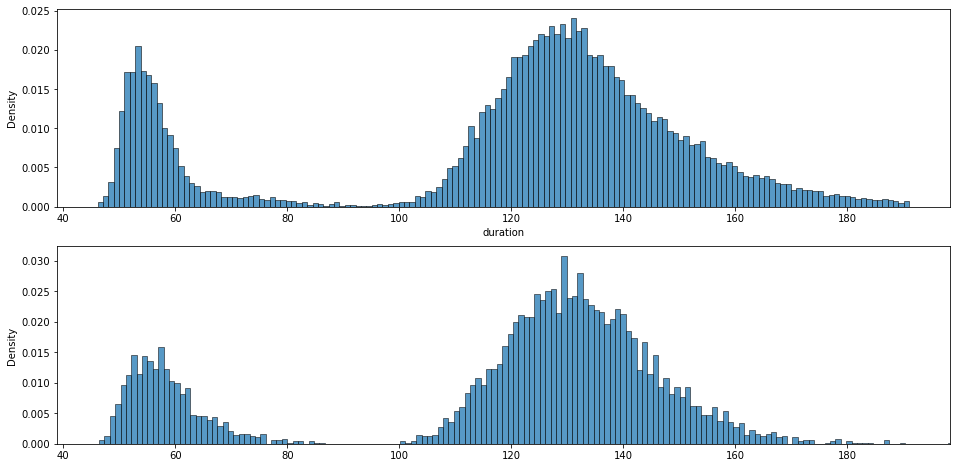

KstestResult(statistic=0.057486894632632346, pvalue=8.968070388956911e-12)
#Samples real: 18687
#Samples dist: 5000


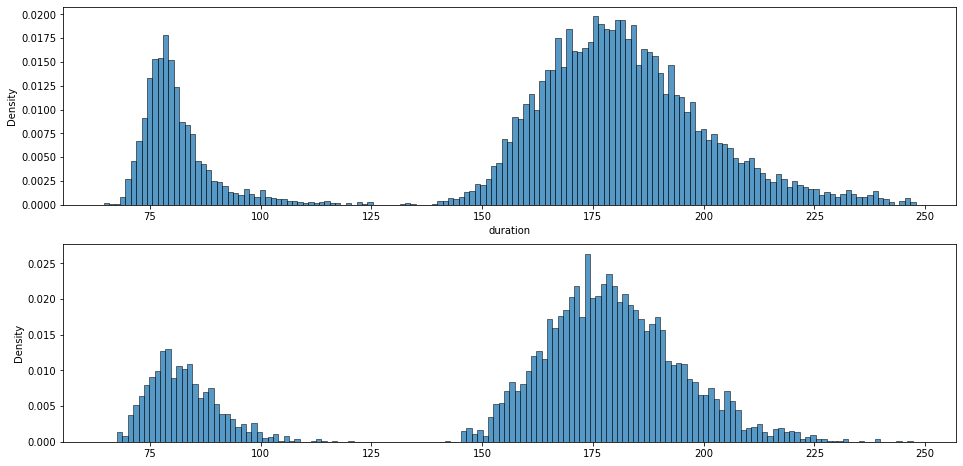

KstestResult(statistic=0.05445566636446056, pvalue=1.1399430288605572e-08)
#Samples real: 8824
#Samples dist: 5000


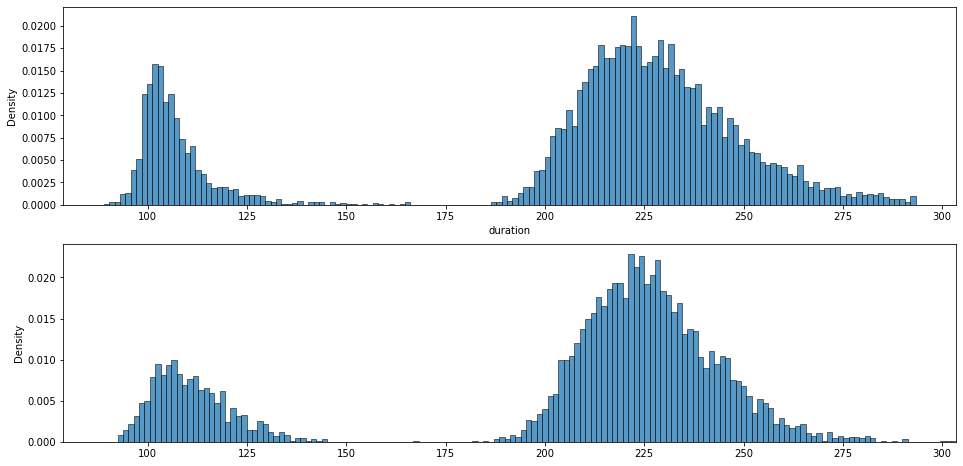

KstestResult(statistic=0.051949296864920655, pvalue=1.427388010011299e-07)
#Samples real: 7751
#Samples dist: 5000


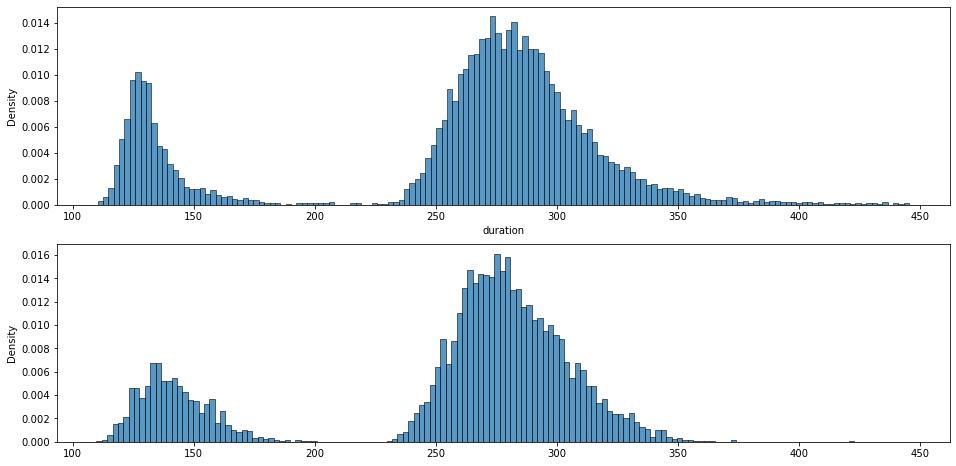

KstestResult(statistic=0.06879227053140097, pvalue=2.575896403652653e-14)
#Samples real: 10350
#Samples dist: 5000


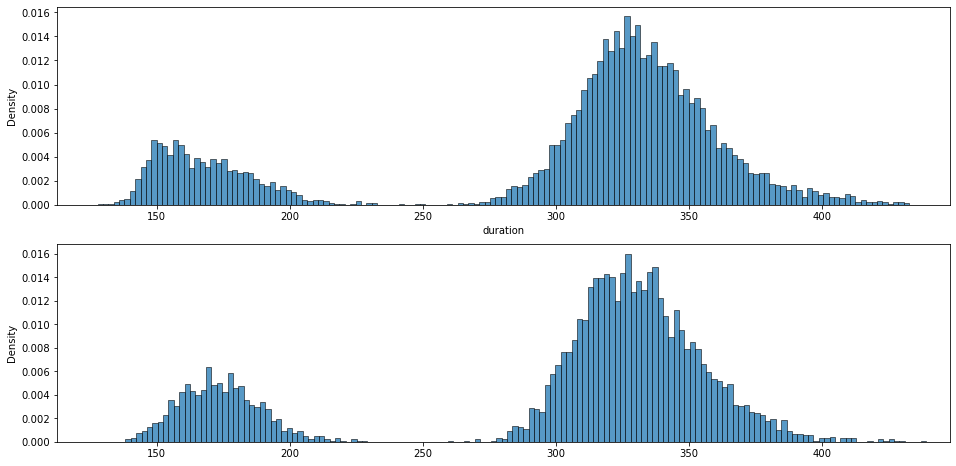

KstestResult(statistic=0.045963584023029865, pvalue=3.5236220760070935e-06)
#Samples real: 8337
#Samples dist: 5000


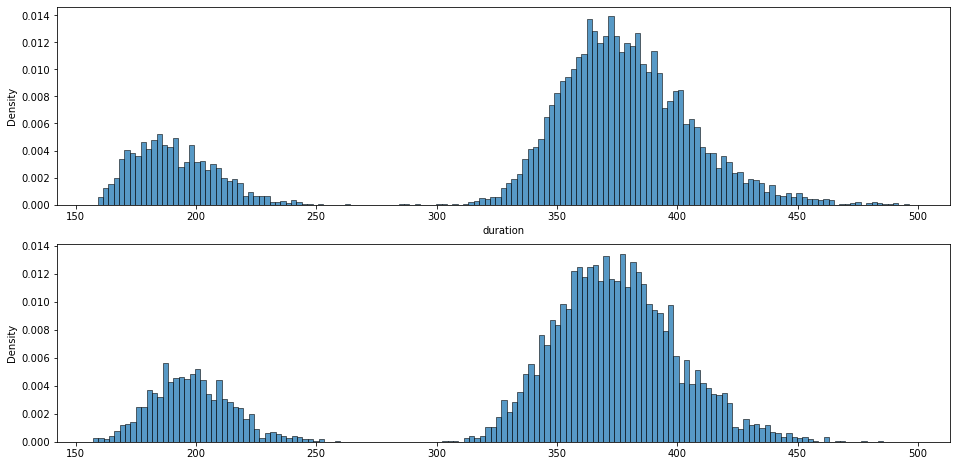

KstestResult(statistic=0.0427947563323952, pvalue=5.1829560349991866e-05)
#Samples real: 6751
#Samples dist: 5000


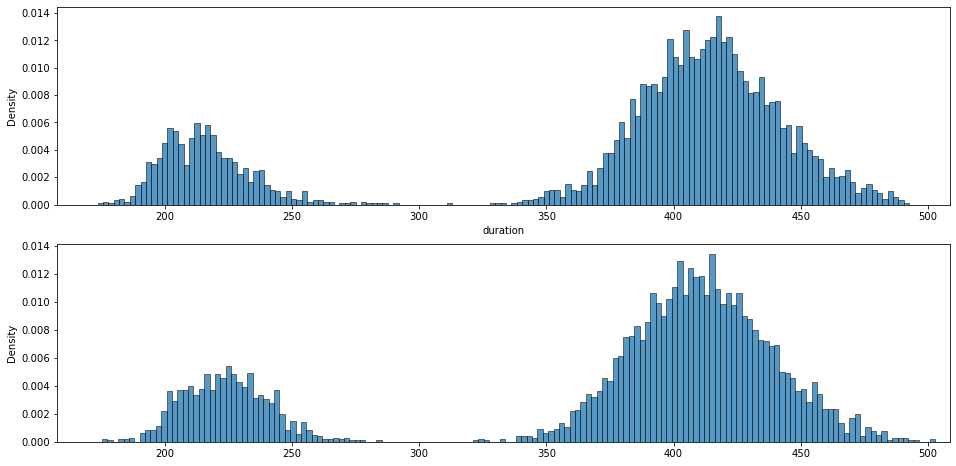

KstestResult(statistic=0.050085913528591354, pvalue=1.7444557094292712e-05)
#Samples real: 4302
#Samples dist: 5000


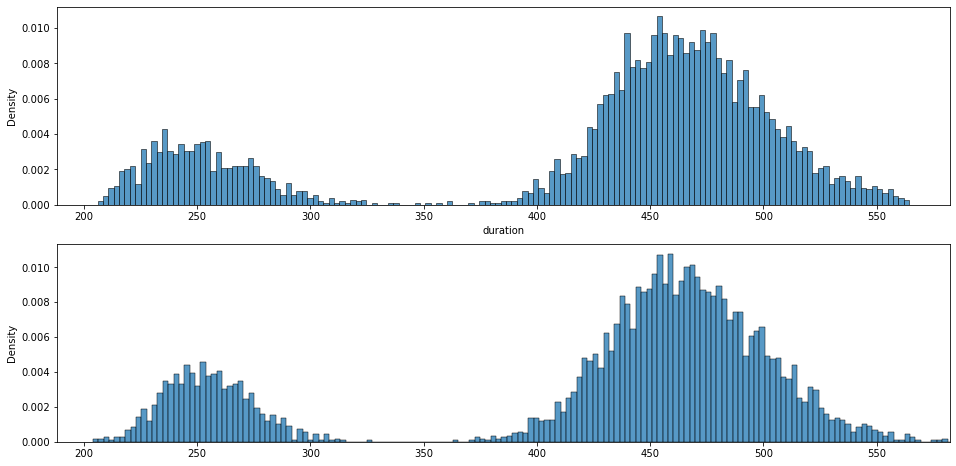

KstestResult(statistic=0.028649208502939845, pvalue=0.04139406398106871)
#Samples real: 4422
#Samples dist: 5000


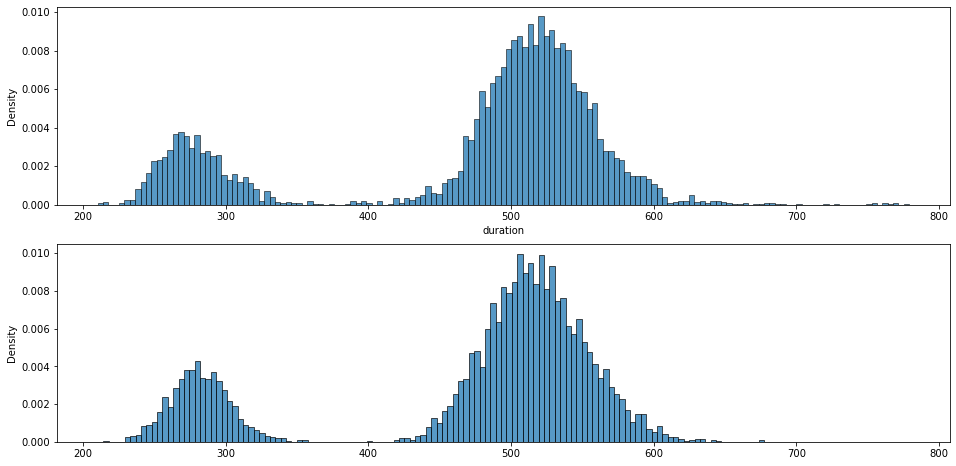

KstestResult(statistic=0.02985592511451902, pvalue=0.022318682060266437)
#Samples real: 5021
#Samples dist: 5000


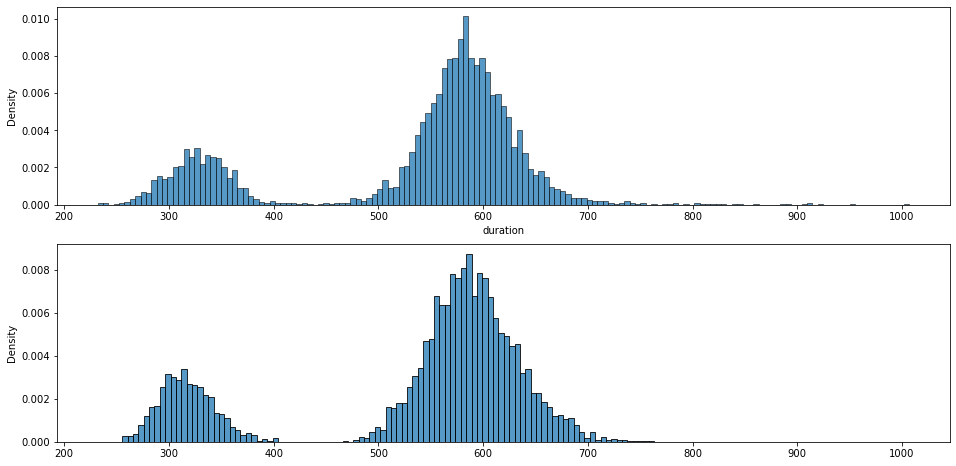

KstestResult(statistic=0.0382975975975976, pvalue=0.0009984882429083797)
#Samples real: 5328
#Samples dist: 5000


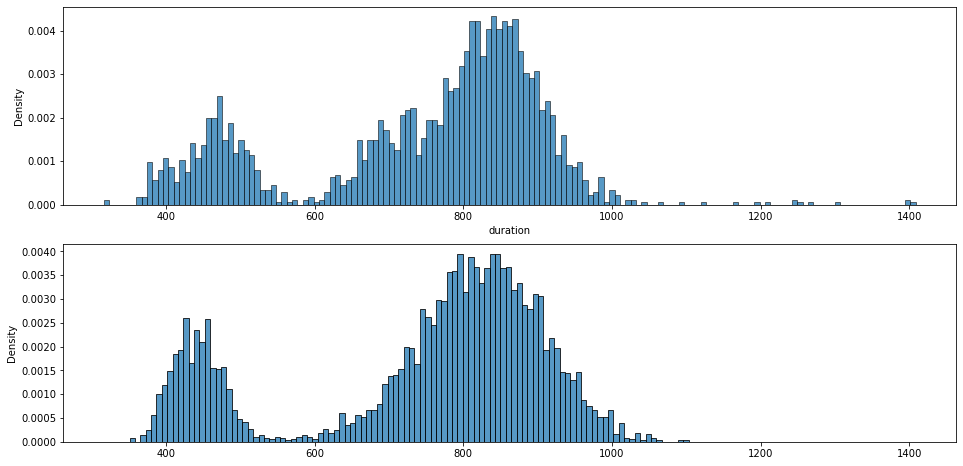

KstestResult(statistic=0.054227748044462745, pvalue=0.00012698402539124132)
#Samples real: 2429
#Samples dist: 5000


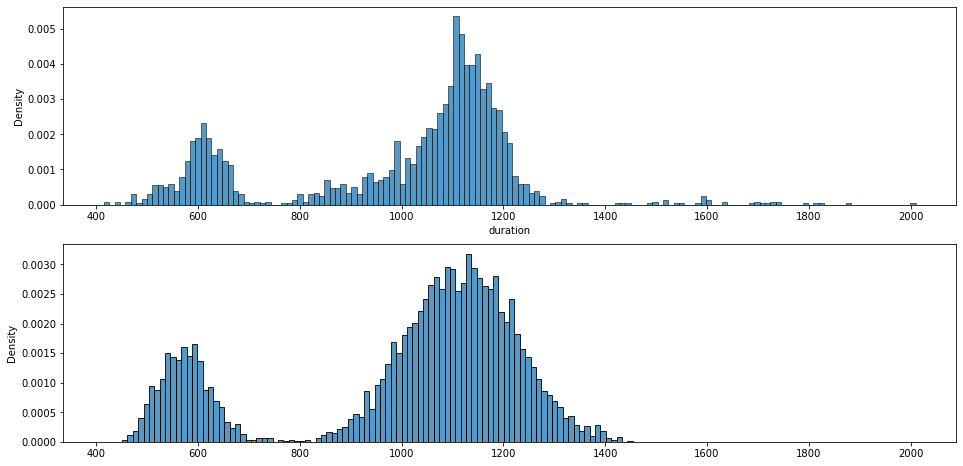

KstestResult(statistic=0.09597359855334539, pvalue=9.541256673628595e-13)
#Samples real: 2212
#Samples dist: 5000


IndexError: list index out of range

In [48]:
# MIXTURE MODEL FROM 2 DISTRIBUTIONS
def plot_validate_dist(samples_for_val_0, samples_for_val_1):
    for index in range(0, 15):
        
        data_dist = np.add(samples_for_val_0[index], samples_for_val_1[index][:len(samples_for_val_0[index])])
        data_dist = np.append(data_dist, samples_for_val_1[index][len(samples_for_val_0[index]):])

        fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,8))

        data_real = data_frames[index*4 + 0]['duration']
        data_real = data_real[data_real.between(data_real.quantile(0), data_real.quantile(.98))]
        data_real = data_real[(data_real <= data_real.mean() + 3*data_real.std()) & (data_real >= data_real.mean() - 3*data_real.std())]

        x_axis_range = int(max(data_real) - min(data_real))
        sns.histplot(data_real, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
        sns.histplot(data_dist, ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
        ax1.set_xlim(ax0.get_xlim())
        plt.show()

        p_value = stats.ks_2samp(data_real, data_dist)
        print(p_value)
        print("#Samples real: " + str(len(data_real)))
        print("#Samples dist: " + str(len(data_dist)))
    
plot_validate_dist(samples_for_val_0, samples_for_val_1)

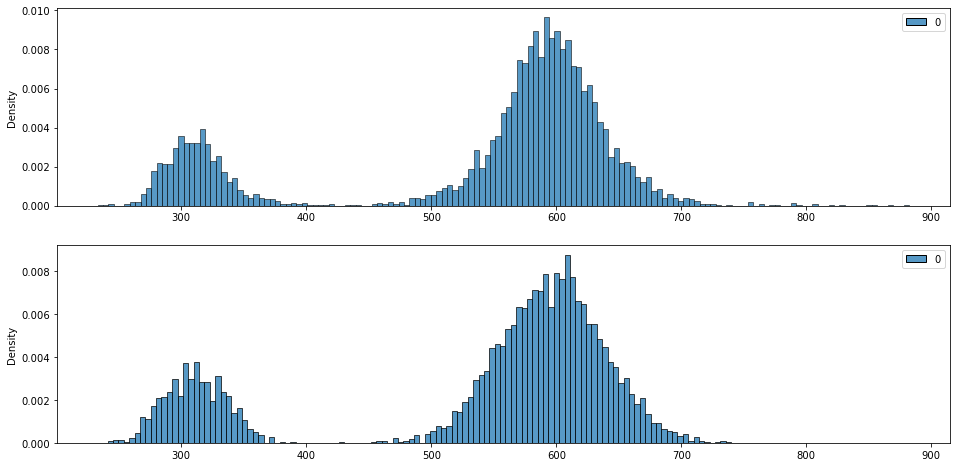

P-value = 0.01570795741362183

[[312.32232671]
 [596.36783231]]

[0.20261235 0.79738765]

[[[ 636.83241584]]

 [[1800.5610019 ]]]


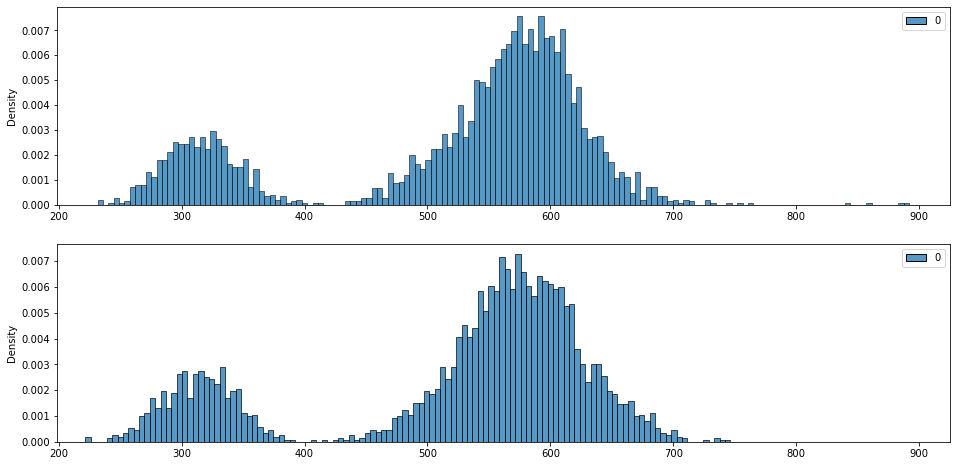

P-value = 0.5781406894818941

[[576.12240687]
 [314.99391588]]

[0.79323333 0.20676667]

[[[2422.79735052]]

 [[ 881.30993692]]]


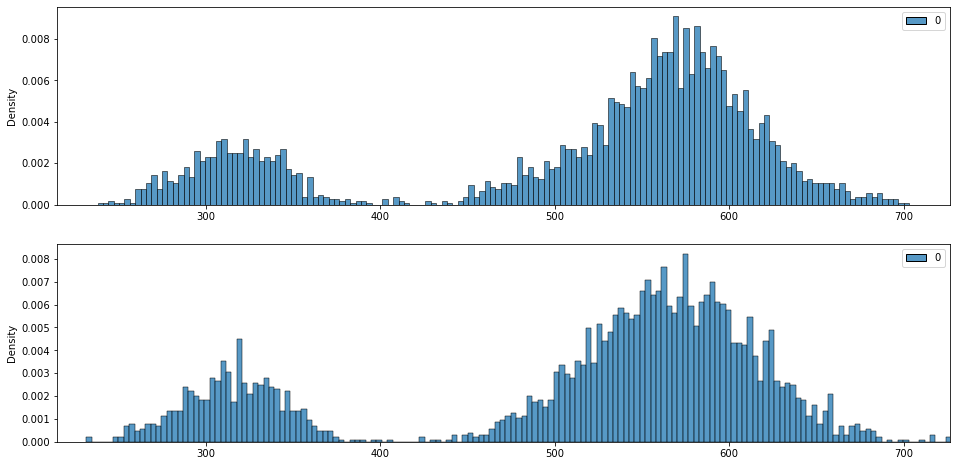

P-value = 0.06029010316507315

[[567.72024533]
 [316.58772479]]

[0.79482883 0.20517117]

[[[2142.43664214]]

 [[ 850.85212507]]]


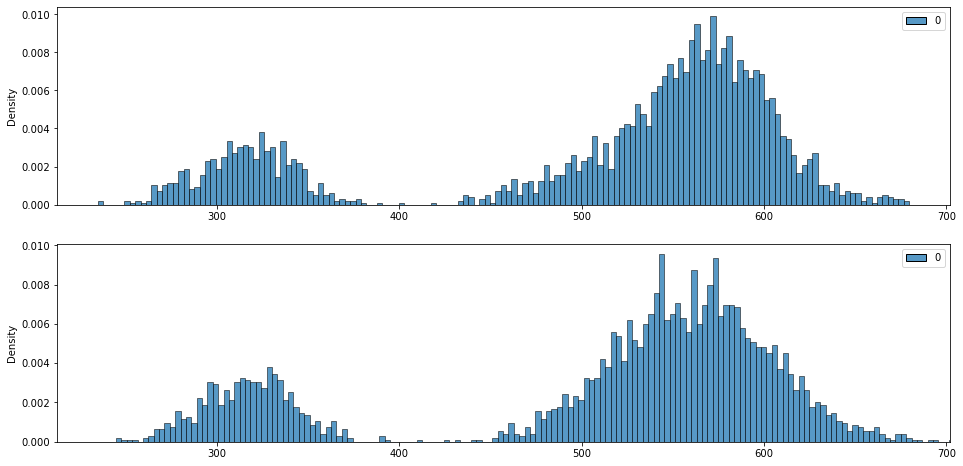

P-value = 0.001052048259145804

[[561.27828502]
 [315.73632646]]

[0.79816553 0.20183447]

[[[1762.67044338]]

 [[ 661.40952084]]]


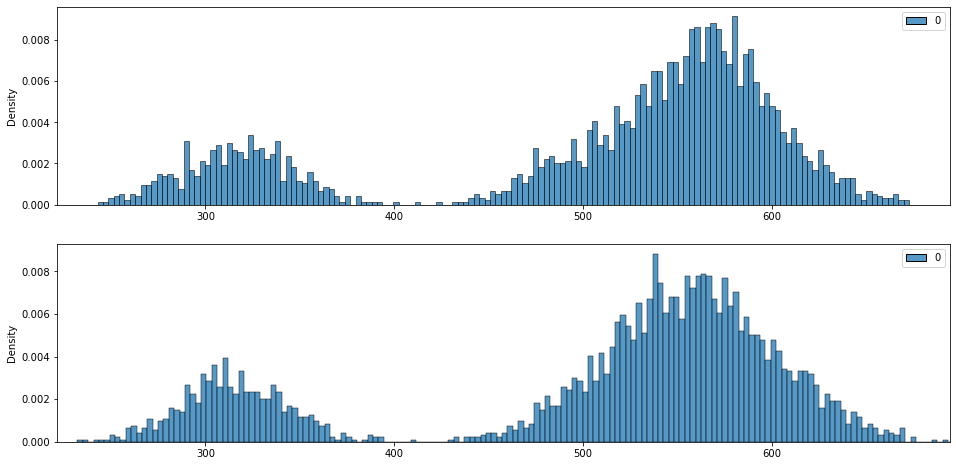

P-value = 0.13764354552731553

[[557.10592313]
 [316.19581901]]

[0.79710539 0.20289461]

[[[1849.43727318]]

 [[ 820.81661697]]]


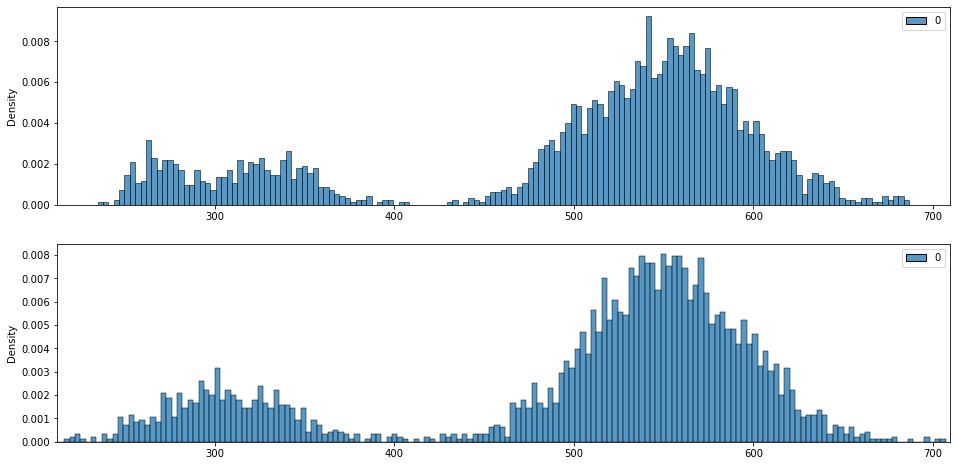

P-value = 0.4081072387418663

[[551.74058204]
 [308.35027415]]

[0.79894465 0.20105535]

[[[1837.91193725]]

 [[1345.43170897]]]


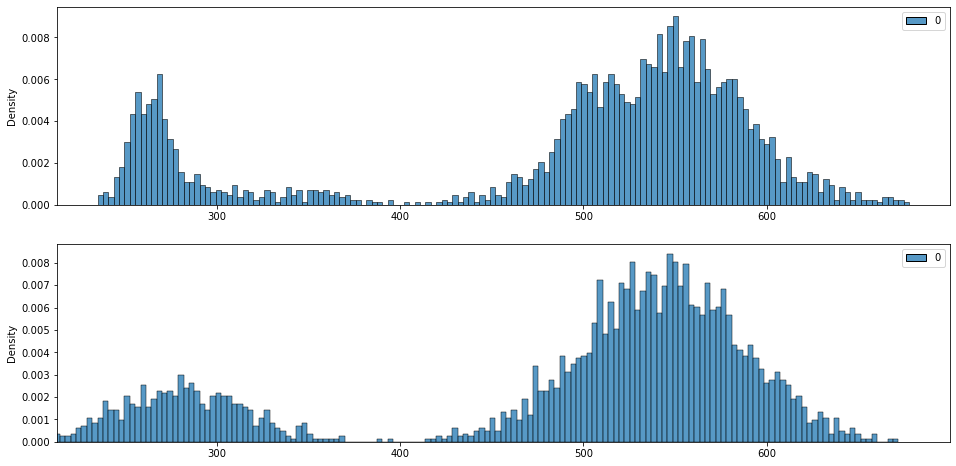

P-value = 0.009654510272519262

[[280.52738824]
 [543.9602557 ]]

[0.20440274 0.79559726]

[[[1105.54563926]]

 [[1849.16928577]]]


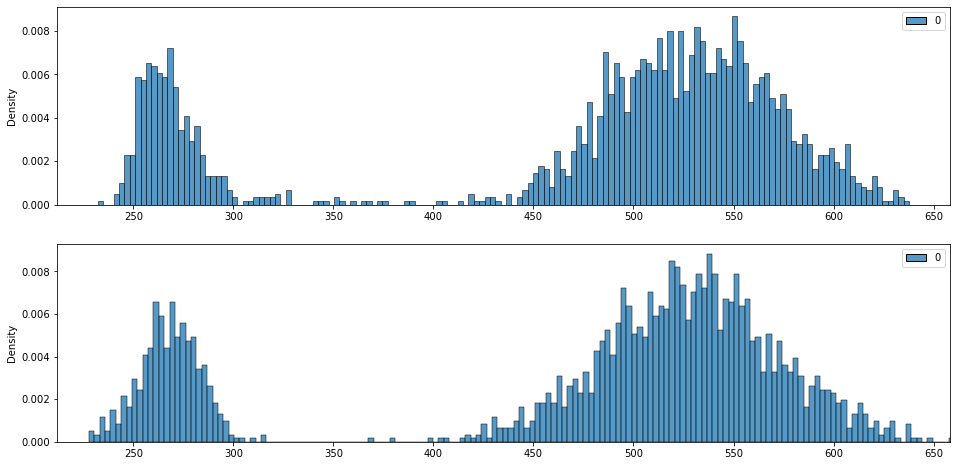

P-value = 0.7406652288601157

[[529.57712368]
 [268.37861311]]

[0.78286348 0.21713652]

[[[1811.52995818]]

 [[ 248.80137944]]]


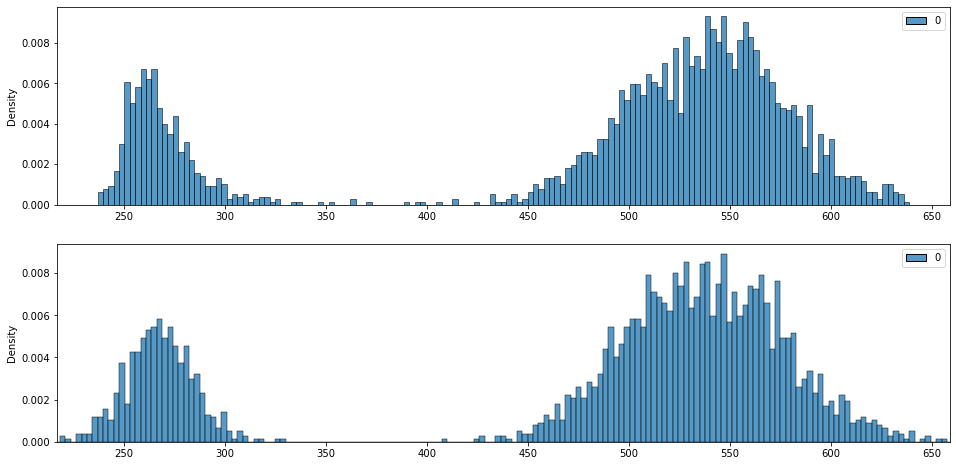

P-value = 0.06397176451026364

[[537.93941382]
 [267.89721384]]

[0.7901112 0.2098888]

[[[1530.04288194]]

 [[ 277.3562915 ]]]


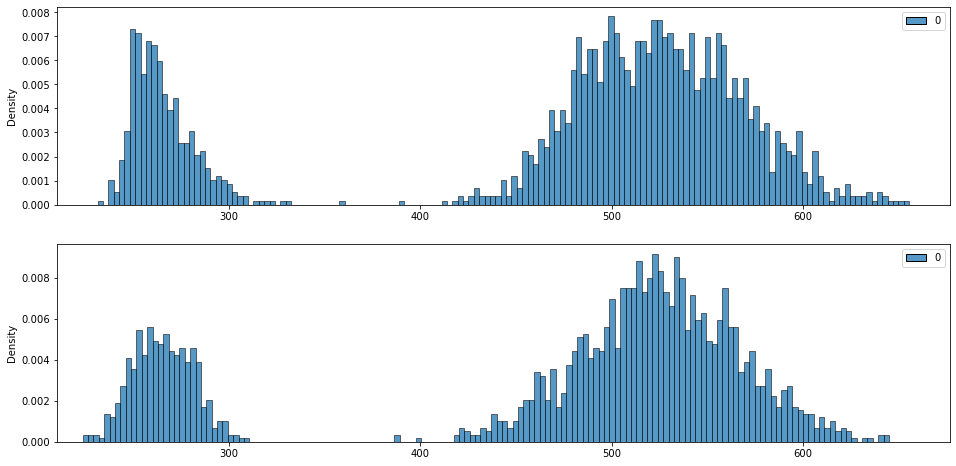

P-value = 0.20545474422731022

[[265.59969696]
 [526.41623008]]

[0.22210701 0.77789299]

[[[ 254.09649135]]

 [[1736.25432085]]]


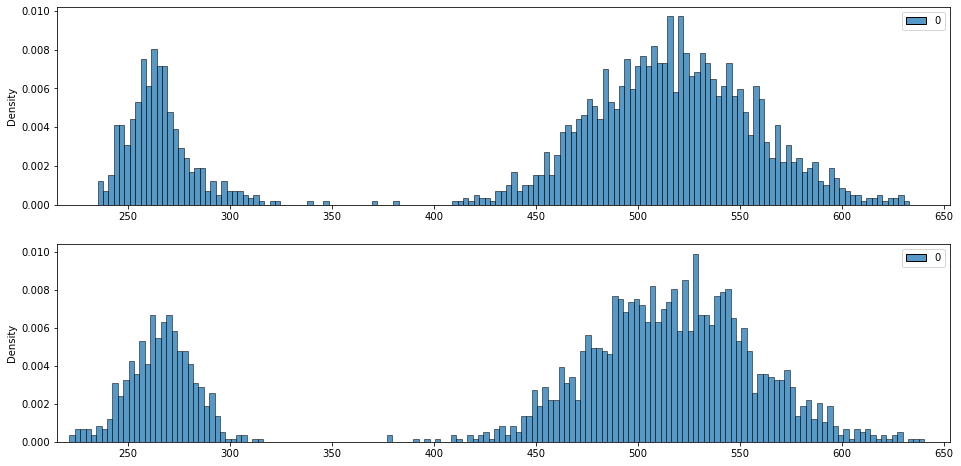

P-value = 0.353474955327225

[[265.22566337]
 [517.50797062]]

[0.2302658 0.7697342]

[[[ 245.56200204]]

 [[1530.24638958]]]


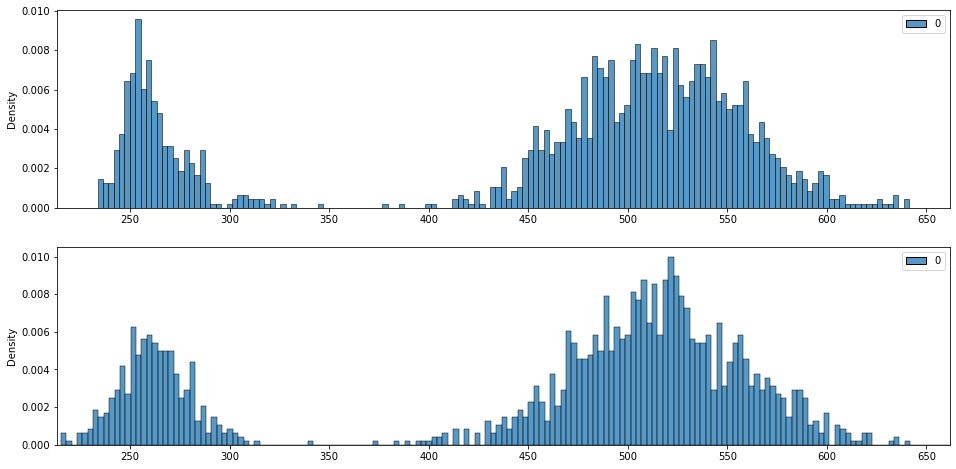

P-value = 0.3627400508087642

[[516.03999538]
 [262.68782279]]

[0.77461595 0.22538405]

[[[1700.24819434]]

 [[ 286.57545814]]]


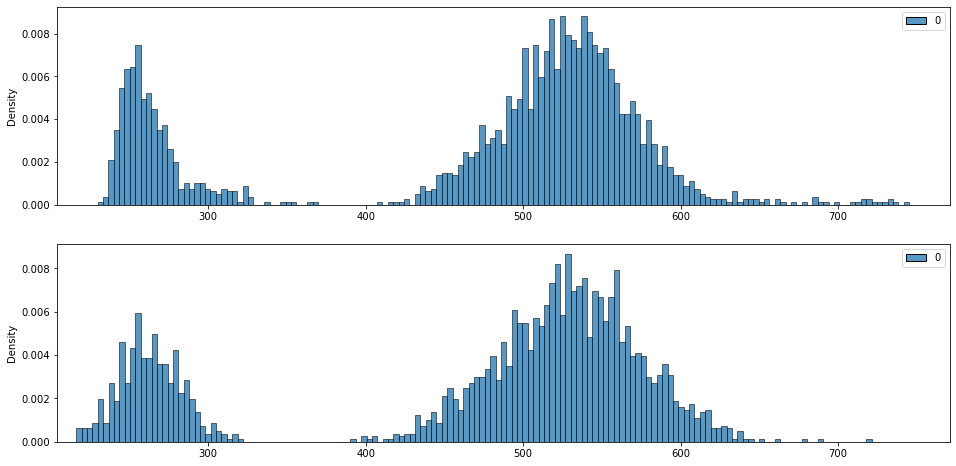

P-value = 0.13279439808556487

[[263.55735581]
 [530.27644375]]

[0.23231383 0.76768617]

[[[ 389.25838947]]

 [[1994.85405936]]]


In [90]:
for index in range(0, 13):
    fig, (ax0, ax1) = plt.subplots(2,1,figsize=(16,8))

    data = data_frames[index*4 + 0]['duration']

    #Clean the data a bit
    data = data[data.between(data.quantile(0), data.quantile(.98))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]
    data = data.values.reshape(-1,1)

    model = mixture.GaussianMixture(n_components=2)
    model.fit(data)
    data_samples = model.sample(len(data))

    x_axis_range = int(max(data) - min(data))
    sns.histplot(data, ax=ax0, stat="density", label="Real Data", binwidth=x_axis_range/150)
    sns.histplot(data_samples[0], ax=ax1, stat="density", label="Real Data", binwidth=x_axis_range/150)
    ax1.set_xlim(ax0.get_xlim())
    plt.show()

    p_value = stats.ks_2samp(np.array(data).flatten(), data_samples[0].flatten())
    print('P-value = ' + str(p_value[1]))
    print()
    print(model.means_)
    print()
    print(model.weights_)
    print()
    print(model.covariances_)

Gamma p score: KstestResult(statistic=0.25508057382114707, pvalue=3.1088277040286016e-292)
Beta p score: KstestResult(statistic=0.20753474262967403, pvalue=1.2987239595167003e-192)
Percentage of data cleaned: 3.2343987823439875
Gamma p score: KstestResult(statistic=0.20924338056567626, pvalue=4.620231807771114e-134)
Beta p score: KstestResult(statistic=0.1598019591982186, pvalue=4.682568537891215e-78)
Percentage of data cleaned: 2.4950939164564057
Gamma p score: KstestResult(statistic=0.2024574509181304, pvalue=2.1135409098567753e-122)
Beta p score: KstestResult(statistic=0.3232141461833222, pvalue=5.89094677e-316)
Percentage of data cleaned: 2.0213687554143807
Gamma p score: KstestResult(statistic=0.21211900381573334, pvalue=9.061379193717999e-128)
Beta p score: KstestResult(statistic=0.3702513158758687, pvalue=0.0)
Percentage of data cleaned: 2.0060790273556233
Gamma p score: KstestResult(statistic=0.19310034826197847, pvalue=2.531060185633915e-108)
Beta p score: KstestResult(statist

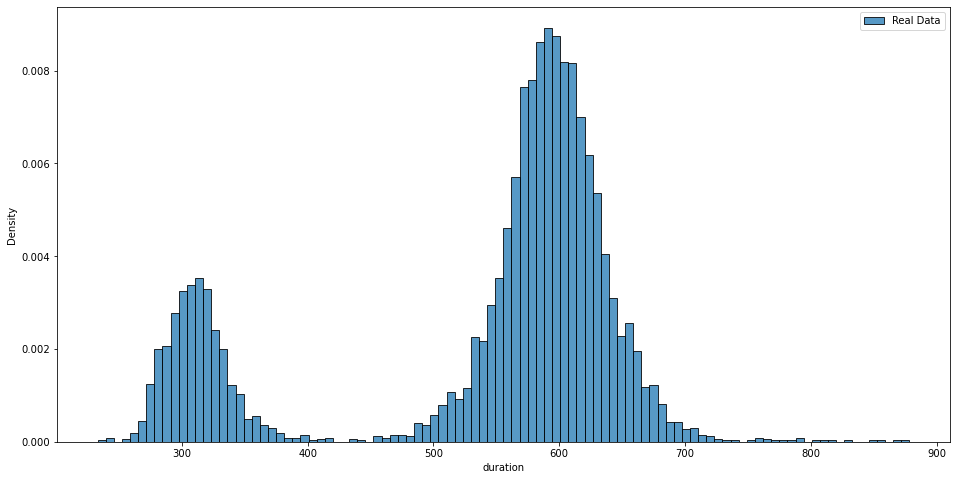

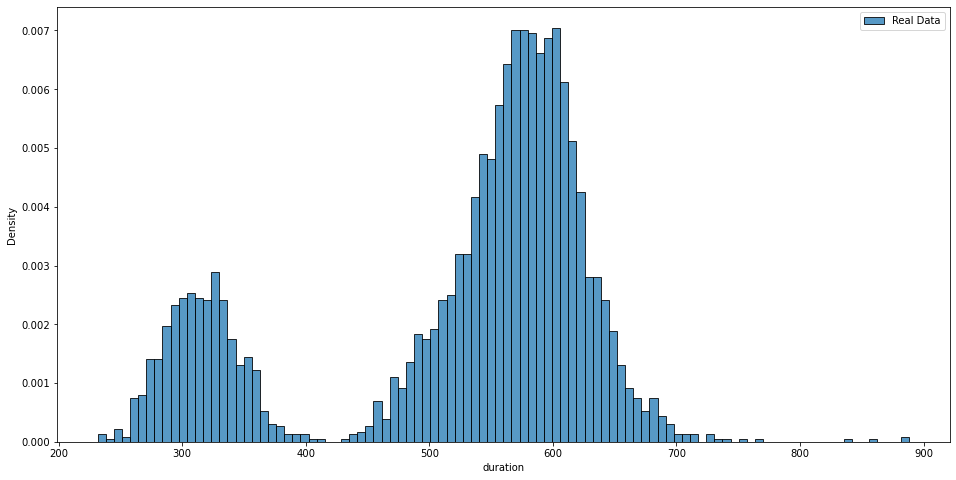

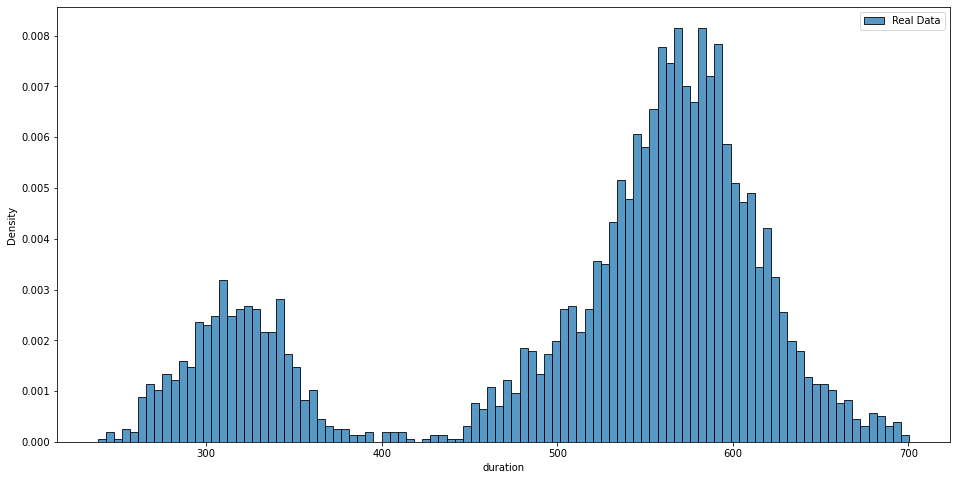

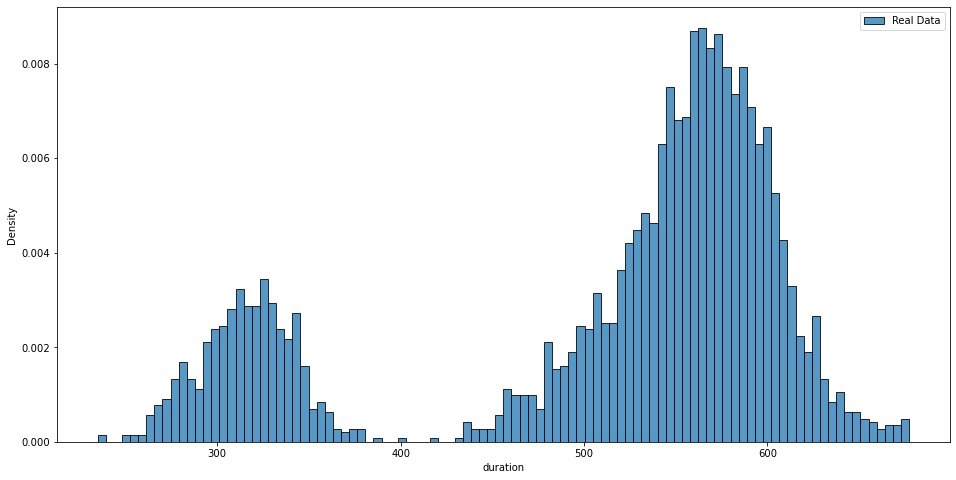

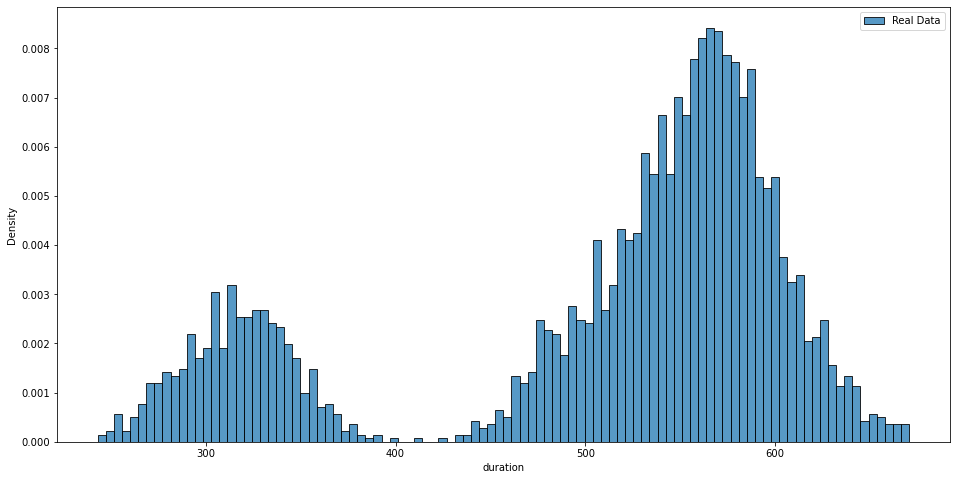

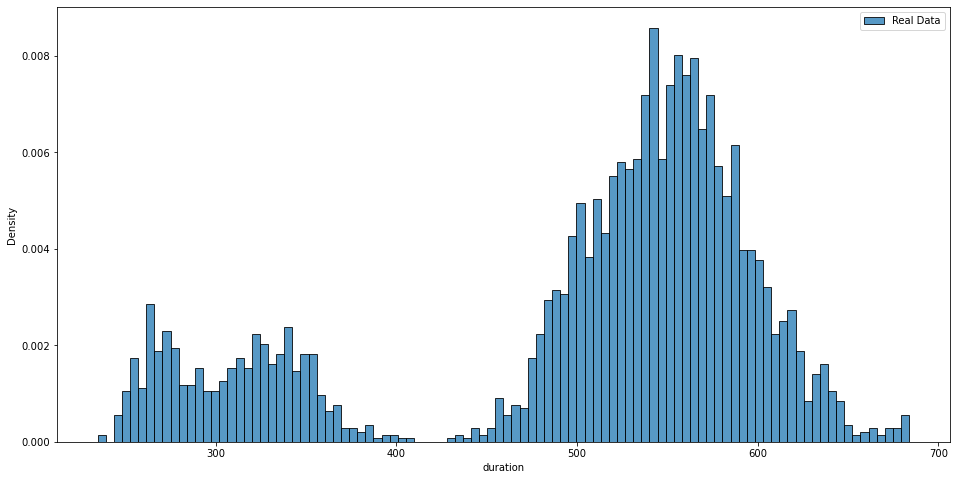

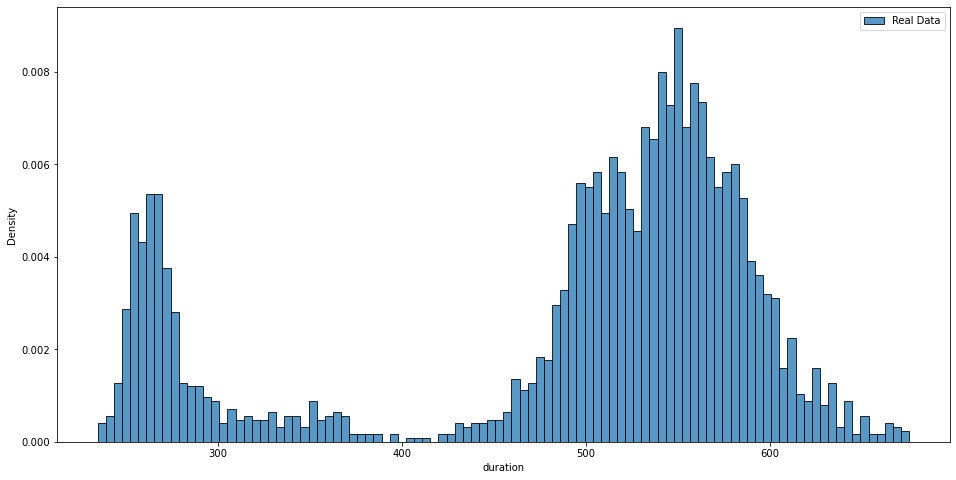

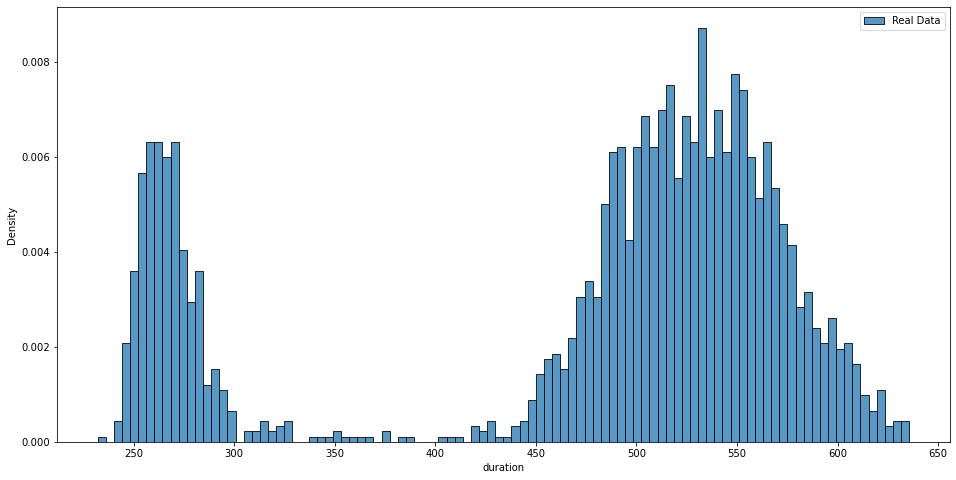

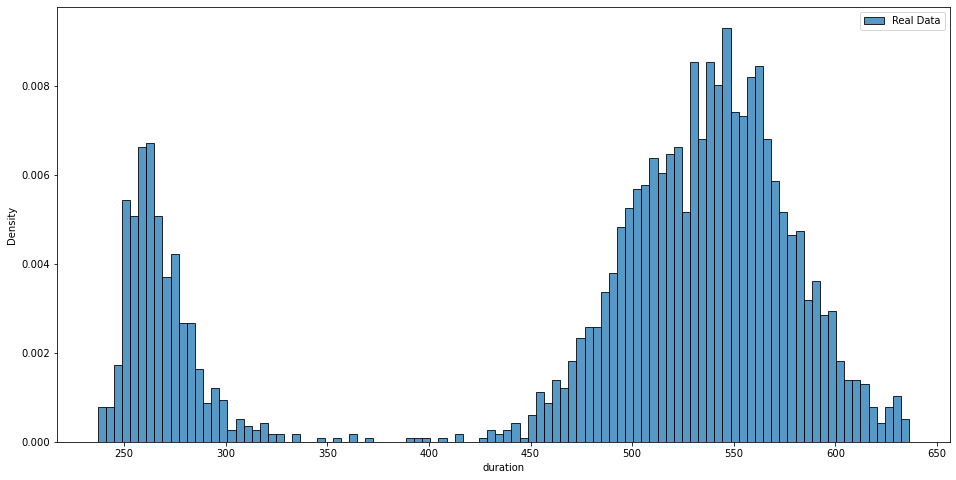

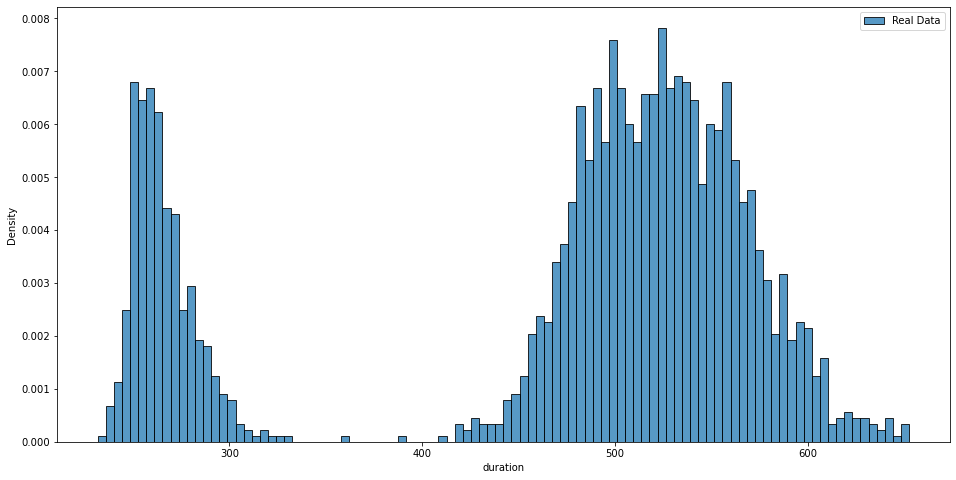

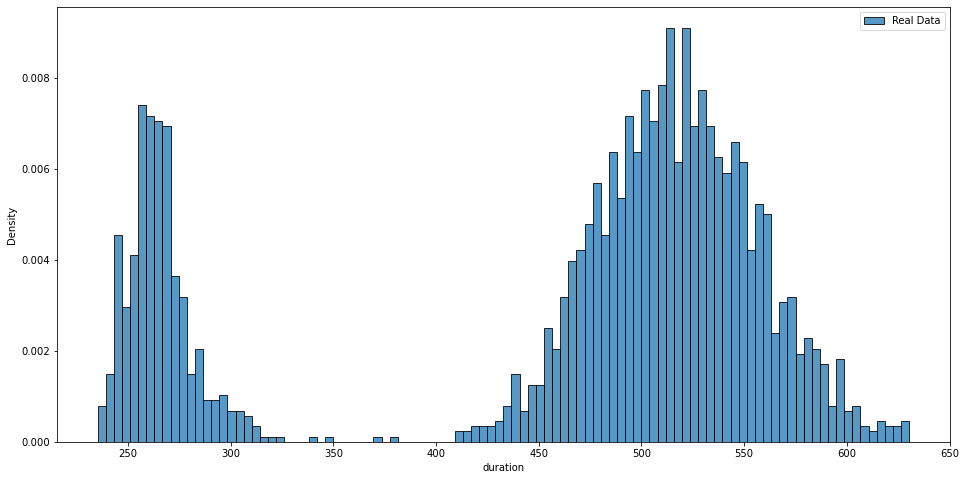

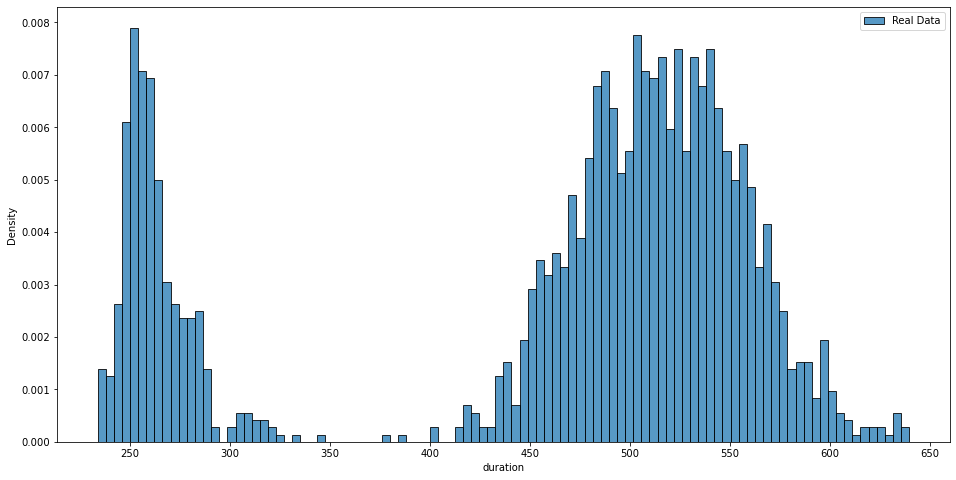

In [64]:
#0 = "/merged/jp_consensus_process_proposal.csv"
#1 = "/merged/jp_consensus_process_new_round.csv"
#2 = "/merged/jp_consensus_ensure_round_and_sync_up.csv"
#3 = "/merged/jp_consensus_process_proposal_without_sync.csv"


#Should work for 2,3 and 4
#Works for 2 and 4
frame_nr = 0
def plot_graphs(x):
    fig, ax = plt.subplots(figsize=(16,8))

    data = data_frames[frame_nr + (x*len(tmp_frames))]['duration']
    
    data = data[data >= 40]

    #Clean the data a bit
    data = data[data.between(data.quantile(0), data.quantile(.98))]
    data = data[(data <= data.mean() + 3*data.std()) & (data >= data.mean() - 3*data.std())]

    sns.histplot(data, ax=ax, stat="density", label="Real Data", bins=100)

    a, loc, scale = stats.gamma.fit(data)
    gamma_fit = stats.gamma(a, loc, scale)
    p_gamma_fit = stats.kstest(data, gamma_fit.cdf)

    alpha, beta, loc, scale = stats.beta.fit(data)
    beta_fit = stats.beta(alpha, beta, loc, scale)
    p_beta_fit = stats.kstest(data, beta_fit.cdf)

    #Fitting the gamma distribution
    X = np.linspace(min(data), max(data), 300)
    #ax.plot(X, gamma_fit.pdf(X), label="Estimated gamma function")
    #ax.plot(X, beta_fit.pdf(X), label="Estimated beta function")
    ax.legend();

    print("Gamma p score: " + str(p_gamma_fit))
    print("Beta p score: " + str(p_beta_fit))
    print("Percentage of data cleaned: " + str((len(data_frames[frame_nr + (x*len(tmp_frames))]['duration']) - len(data)) / len(data_frames[frame_nr + (x*len(tmp_frames))]['duration']) * 100))
    
for x in range(0, 12):
    plot_graphs(x)